In [ ]:
!pip install autogluon.timeseries
!pip install holidays


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import holidays
from datetime import datetime, timedelta

In [ ]:


# Load your dataset
data = pd.read_csv("/content/drive/MyDrive/sales forecasting project/train.csv", parse_dates=["date"])

# Aggregate by item and date (e.g., take average)
data = data.groupby(['item', 'date'], as_index=False)['sales'].sum()
#this functiuon reduces the outliers effect on calculations and predictions
data['sales'] = np.log1p(data['sales'])  # Apply log(1 + x) transformation
# Rename columns for AutoGluon


# Check the result
print(data.head())


   item       date     sales
0     1 2013-01-01  4.897840
1     1 2013-01-02  4.605170
2     1 2013-01-03  4.852030
3     1 2013-01-04  4.983607
4     1 2013-01-05  5.010635


In [ ]:

#AutoGluon expects these default column names internally in many of its tools
data.dropna()
data = data.rename(columns={'sales': 'target','date':'timestamp','item':'item_id'})
data.sort_values(by=['item_id','timestamp'],inplace=True)
data.reset_index(drop=True,inplace=True)
data.head()

,item_id,timestamp,target
0,1,2013-01-01,4.897840
1,1,2013-01-02,4.605170
2,1,2013-01-03,4.852030
3,1,2013-01-04,4.983607
4,1,2013-01-05,5.010635


In [ ]:
us_holidays = holidays.US(years=range(2012, 2026))

def create_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()

    # Holiday-based features
    df["is_holiday"] = df["timestamp"].isin(us_holidays).astype(float)
    df["is_pre_holiday"] = df["timestamp"].isin([d - timedelta(days=1) for d in us_holidays]).astype(float)
    df["is_post_holiday"] = df["timestamp"].isin([d + timedelta(days=1) for d in us_holidays]).astype(float)

    # Time features
    df['dayofweek'] = df["timestamp"].dt.dayofweek
    df['quarter'] = df["timestamp"].dt.quarter
    df['month'] = df["timestamp"].dt.month
    df['year'] = df["timestamp"].dt.year
    df['dayofyear'] = df["timestamp"].dt.dayofyear
    df['dayofmonth'] = df["timestamp"].dt.day
    df['weekofyear'] = df["timestamp"].dt.isocalendar().week

    # Fourier terms for seasonality
    df['fourier_sin_365'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['fourier_cos_365'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

    return df

# Apply to your data
data = create_time_features(data)


<ipython-input-5-3422610445>:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df["timestamp"].isin(us_holidays).astype(float)
<ipython-input-5-3422610445>:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_pre_holiday"] = df["timestamp"].isin([d - timedelta(days=1) for d in us_holidays]).astype(float)
<ipython-input-5-3422610445>:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame

ts_data = TimeSeriesDataFrame.from_data_frame(
    df=data,
    id_column='item_id',
    timestamp_column='timestamp'
)
# Define prediction length
prediction_length = 30

# Split into training and testing sets
train_data = ts_data.slice_by_timestep(None, -prediction_length)
test_data = ts_data.slice_by_timestep(-prediction_length, None)

In [ ]:
from autogluon.timeseries import TimeSeriesPredictor



# Create the predictor and fine-tune the model
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    eval_metric= "MAPE",
    known_covariates_names = [
    "is_holiday",
    "is_pre_holiday",
    "is_post_holiday",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "fourier_sin_365",
    "fourier_cos_365"
    ],
    freq="D"
)

predictor.fit(
    train_data,
    presets="best_quality",
    enable_ensemble=True,
    time_limit=600  # Limit training to 10 minutes (adjust as needed)
)


Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20250613_170653'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       11.28 GB / 12.67 GB (89.0%)
Disk Space Avail:   70.19 GB / 112.64 GB (62.3%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': ['is_holiday',
                            'is_pre_holiday',
                            'is_post_holiday',
                            'dayofweek',
                            'quarter',
                            'month',
                            'year',
                            'dayofyear',
                      

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.0283       = Validation score (-MAPE)
	29.45   s     = Training runtime
	1.78    s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_small]. Training for up to 66.9s of the 401.1s of remaining time.


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	Saving fine-tuned model to /content/AutogluonModels/ag-20250613_170653/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	Saving fine-tuned model to /content/AutogluonModels/ag-20250613_170653/models/ChronosFineTuned[bolt_small]/W1/fine-tuned-ckpt
	-0.0063       = Validation score (-MAPE)
	63.97   s     = Training runtime
	0.19    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 67.4s of the 337.0s of remaining time.
	-0.0222       = Validation score (-MAPE)
	64.61   s     = Training runtime
	0.16    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 68.0s of the 272.1s of remaining time.
	-0.0299       = Validation score (-MAPE)
	64.91   s     = Training runtime
	0.56    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 68.9s of the 206.6s of remaining time.
	-0.0375       = Validation score (-MAPE)
	65.52   s     = Training runtim

In [ ]:

# Generate future timestamps for known covariates
known_covariates = predictor.make_future_data_frame(train_data)

known_covariates = create_time_features(known_covariates)

<ipython-input-5-3422610445>:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df["timestamp"].isin(us_holidays).astype(float)
<ipython-input-5-3422610445>:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_pre_holiday"] = df["timestamp"].isin([d - timedelta(days=1) for d in us_holidays]).astype(float)
<ipython-input-5-3422610445>:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype

In [ ]:

# Predict
predictions = predictor.predict(train_data, known_covariates=TimeSeriesDataFrame.from_data_frame(known_covariates))


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [ ]:

import numpy as np
from sklearn.metrics import mean_absolute_error

# Get median predictions (column '0.5')
median_preds = predictions["0.5"]

# Align true values (test data target)
true_values = test_data['target'].sort_index()
pred_values = median_preds.sort_index()
true_values = np.expm1(true_values)
pred_values = np.expm1(pred_values)
# Calculate MAE
mae = mean_absolute_error(true_values, pred_values)
print(f'Mean Absolute Error (Median Prediction): {mae}')


Mean Absolute Error (Median Prediction): 17.405272638357268


In [ ]:
import matplotlib.pyplot as plt

def plot_forecast_vs_actual(test_data, predictions, item_id, target_col='target'):
    test_series = test_data.loc[item_id][target_col]
    pred_series = predictions.loc[item_id]['0.5']  # Use median prediction

    plt.figure(figsize=(12, 6))

    # Plot actual test data
    plt.plot(test_series.index, test_series.values, label='Actual (Test)', color='green')

    # Plot predicted data
    plt.plot(pred_series.index, pred_series.values, label='Predicted', color='red', linestyle='--')

    plt.title(f'Forecast vs Actual for {item_id}')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


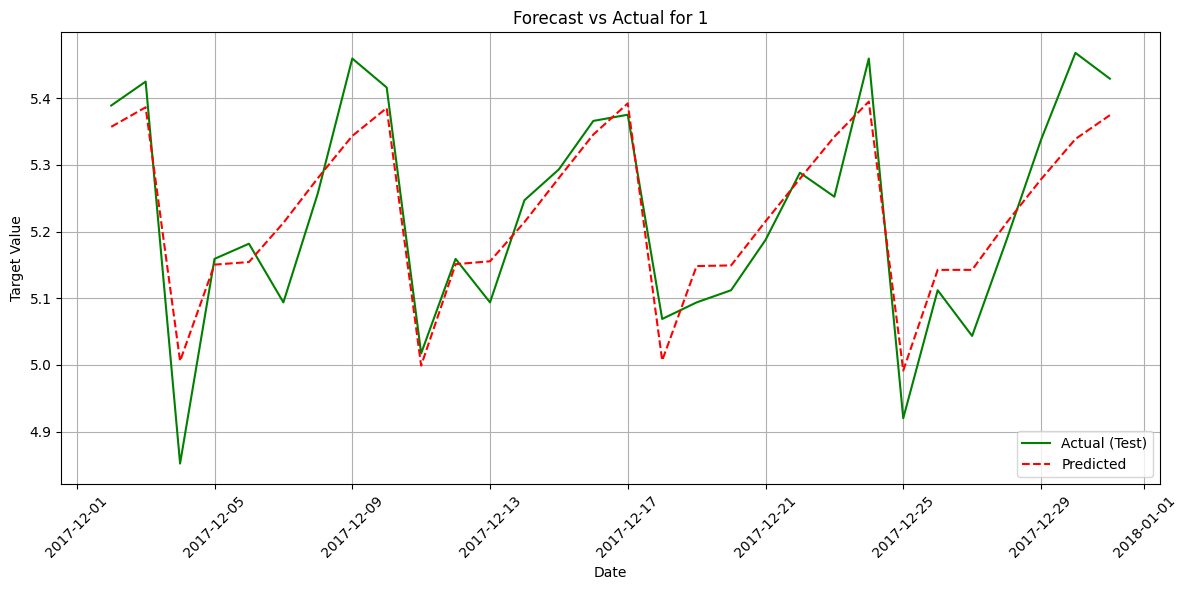

In [ ]:
plot_forecast_vs_actual(test_data, predictions, item_id=1)
